In [5]:
from Binaries import *
from scipy.optimize import curve_fit

def neg_exponential(x, a, b):
    return a * np.exp(- b * x)

plt.rcParams["figure.figsize"] = [20, 10]

In [2]:
import uproot

file = uproot.open("/cr/tempdata01/filip/iRODS/MonitoringData/mc_2022_03_17_00h00.root:SDMonCal")
StationIDs = file['SDMonCalBranch']['fLsId'].array()
data = file['fCalibration']

Nuria = StationIDs == 56

x = []

starts = data['fCalibration.fStartSecond'].array()[Nuria]
deltas = data['fCalibration.fEndSecond'].array()[Nuria]

for j, trigger in enumerate(['fCalibration.fT2', 'fCalibration.fTotRate', 'fCalibration.fTotD']): # , 'fCalibration.fMops']):

    if j != 1: x.append(data[trigger].array()[Nuria] / deltas)
    else: x.append(data[trigger].array()[Nuria])

Th2 = x[0]
ToTd = x[1]+ x[2]
Total = Th2 + ToTd

Th2, Th2_err = np.mean(Th2), np.std(Th2)
ToTd, ToTd_err = np.mean(ToTd), np.std(ToTd)
Total, Total_err = np.mean(Total), np.std(Total)

print(Total, Total_err)
print(Th2, Th2_err)
print(ToTd, ToTd_err)

25.13653612453502 0.6334867738721564
22.687841530054648 0.5791905344760836
2.448694594480373 0.1922507711802837


Total rate surplus: 	11.50%
Th2 rate surplus: 	10.68%
ToT(d) rate surplus: 	17.96%


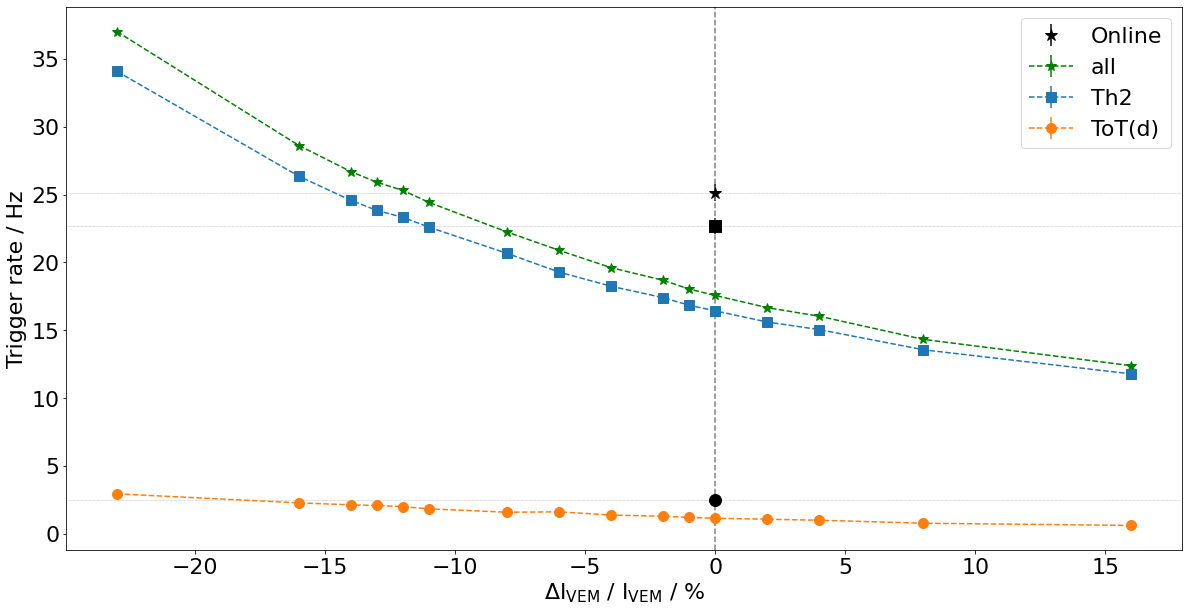

In [16]:
r_th2, r_tot = [], []
e_th2, e_tot = [], []
x, r_total = [], []
e_total = []

for file in os.listdir("./trigger_output"):

    t, th2, tot, tod = np.loadtxt("/cr/users/filip/Trigger/RunProductionTest/trigger_output/" + file, unpack = True, usecols = [2,4,5,6])

    p = file.split("_")[-1][:-4]

    try:
        x.append(float(p[1:]) if p[0] == "p" else -1 * float(p[1:]))
    except ValueError: x.append(0)

    duration = t.sum()
    rate_th2 = th2.sum() / duration
    rate_tot = tot.sum() / duration
    rate_tod = tod.sum() / duration
    error_th2 = np.std(th2)
    error_tot = np.std(tot)
    error_tod = np.std(tod)

    r_th2.append(rate_th2)
    r_tot.append(rate_tot + rate_tod)

    rate_total = rate_th2 + rate_tot + rate_tod
    error_total = np.sqrt(error_th2**2 + error_tot**2 + error_tod**2)
    r_total.append(rate_total)
    
    e_th2.append(error_th2 / duration)
    e_tot.append(np.sqrt(error_tot**2 + error_tod**2) / duration)
    e_total.append(error_total / duration)

ii = np.argsort(x)
x = np.array(x)[ii]
r_total = np.array(r_total)[ii]
r_th2 = np.array(r_th2)[ii]
r_tot = np.array(r_tot)[ii]

X = np.linspace(-23, 16, 100)
popt_total, pcov = curve_fit(neg_exponential, x, r_total, bounds = (0, np.inf), p0 = [r_total[11], 1])
# plt.plot(X, neg_exponential(X, *popt_tot))
popt_th2, pcov = curve_fit(neg_exponential, x, r_th2, bounds = (0, np.inf), p0 = [r_th2[11], 1])
# plt.plot(X, neg_exponential(X, *popt_th2))
popt_tot, pcov = curve_fit(neg_exponential, x, r_tot, bounds = (0, np.inf), p0 = [r_tot[11], 1])
# plt.plot(X, neg_exponential(X, *popt_tot))

plt.errorbar(0, Total, yerr = Total_err, fmt = "k*", label = "Online", markersize = 12)
plt.errorbar(0, ToTd, yerr = ToTd_err, fmt = "ko", markersize = 12)
plt.errorbar(0, Th2, yerr = Th2_err, fmt = "ks", markersize = 12)

plt.errorbar(x, r_total, yerr = e_total, fmt = "--g*", label ="all", markersize = 10)
plt.errorbar(x, r_th2, yerr = e_th2, fmt = "--s", label ="Th2", markersize = 10)
plt.errorbar(x, r_tot, yerr = e_tot, fmt = "--o", label ="ToT(d)", markersize = 10)
plt.axhline(Total, ls = ":", lw = 0.5, c = "gray")
plt.axhline(ToTd, ls = ":", lw = 0.5, c = "gray")
plt.axhline(Th2, ls = ":", lw = 0.5, c = "gray")

plt.axvline(0, c = "gray", ls = "--")
plt.xlabel(r"$\Delta$I$_\mathrm{VEM}$ / I$_\mathrm{VEM}$ / %")
plt.ylabel("Trigger rate / Hz")
plt.legend()

print(f"Total rate surplus: \t{np.log(Total/popt_total[0])/popt_total[1]:.2f}%")
print(f"Th2 rate surplus: \t{np.log(Th2/popt_th2[0])/popt_th2[1]:.2f}%")
print(f"ToT(d) rate surplus: \t{np.log(ToTd/popt_tot[0])/popt_tot[1]:.2f}%")